## Download testing data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import driveanon

In [3]:
# %%capture
# driveanon.save('13agtkTBW9HydkjwnquIt6axiDvbg1D9p', filename='data.tar.gz')
# ! tar -xzvf data.tar.gz
# ! rm data.tar.gz

## Plot difference maps

In [4]:
import glacierpoly as gpoly
import glob
import geopandas as gpd

In [7]:
reference_dem_file = '/mnt/Backups/knuth/paper/south_cascade/final_products/scg_test_data/reference_dem.tif'
reference_glacier_polygon_file = '/mnt/Backups/knuth/paper/south_cascade/final_products/scg_test_data/rgi_glacier_oultine.geojson'
difference_maps_files = sorted(glob.glob('/mnt/Backups/knuth/paper/south_cascade/final_products/scg_test_data/dod*.tif'))

In [9]:
gpoly.core.contour_polygon_by_elevation(reference_dem_file, 
                             reference_glacier_polygon_file, bins=10)

'/mnt/Backups/knuth/paper/south_cascade/final_products/scg_test_data/reference_dem_contoured.geojson'

In [5]:
diffs = sorted(glob.glob('data/diff*.tif'))
gdf = gpd.read_file('data/south_cascade_rgi_polygon.geojson')

'data/diff_dem_ref_1970-09-29.tif'

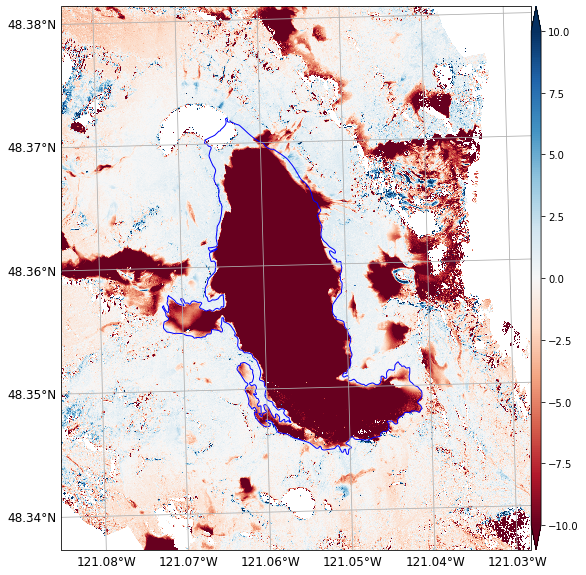

In [6]:
gpoly.plotting.plot_tif(diffs[0], 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
diffs[0]

'data/diff_dem_ref_1994-09-06.tif'

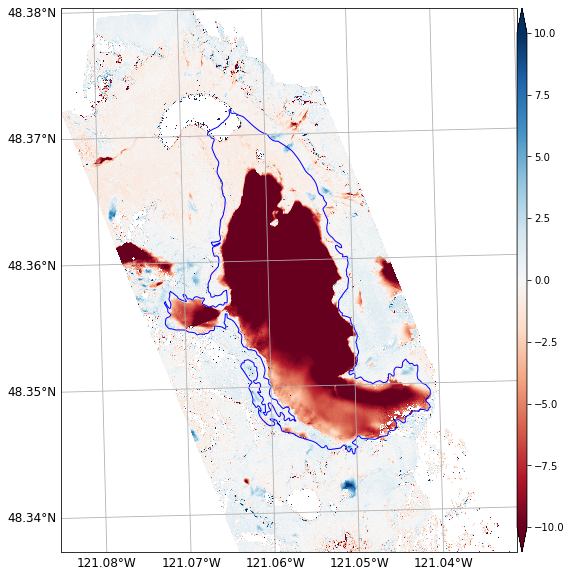

In [7]:
gpoly.plotting.plot_tif(diffs[-3], 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
diffs[-3]

## Detect edges

In [364]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [365]:
source = rasterio.open(diffs[0],masked=True)
array = source.read(1)

In [366]:
# def f(x, y):
#     return np.sin(x ** 2 + y ** 2)

# x = np.arange(0, source.shape[1], 1)
# y = np.arange(0, source.shape[0], 1)

# X, Y = np.meshgrid(x, y)
# rand = f(X, Y)
# mask = array == source.nodata
# array[mask] = rand[mask]

In [367]:
array = np.uint8(array)
canny = cv2.Canny(array,50,150)

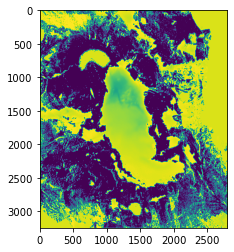

In [368]:
plt.imshow(array)

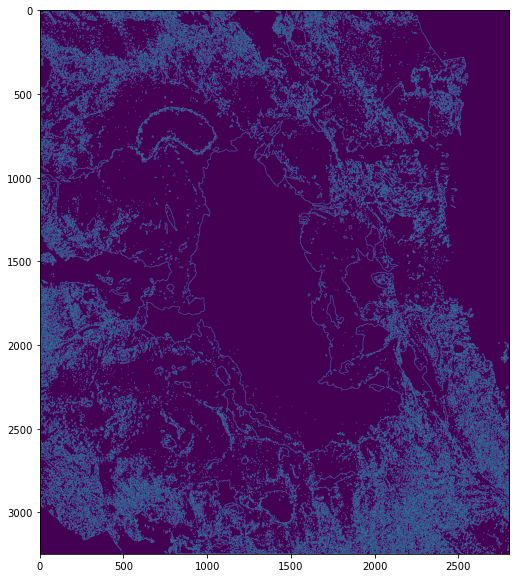

In [369]:
fig,ax = plt.subplots(figsize=(10,10))
ax.imshow(canny)

## isolate largest blob

In [466]:
from skimage.morphology import (erosion, dilation, closing, opening,
                                area_closing, area_opening)
from skimage.measure import label, regionprops, regionprops_table

In [467]:
square = np.array([[1,1,1],
                   [1,1,1],
                   [1,1,1]])
def multi_dil(im, num, element=square):
    for i in range(num):
        im = dilation(im, element)
    return im
def multi_ero(im, num, element=square):
    for i in range(num):
        im = erosion(im, element)
    return im

In [468]:
multi_dilated = multi_dil(canny, 4)

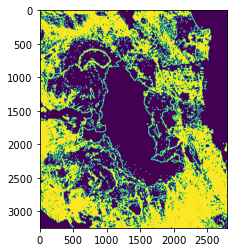

In [469]:
plt.imshow(multi_dilated)

In [470]:
area_closed = area_closing(multi_dilated, 1000000)

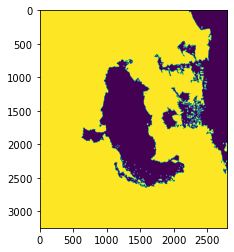

In [471]:
plt.imshow(area_closed)

In [472]:
multi_eroded = multi_ero(area_closed, 10)

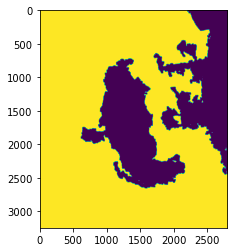

In [473]:
plt.imshow(multi_eroded)

In [474]:
opened = opening(multi_eroded)

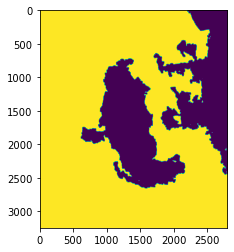

In [475]:
plt.imshow(opened)

In [476]:
label_im = label(opened)
regions = regionprops(label_im)

/home/knuth/sw/miniconda3/envs/glacierpoly/lib/python3.8/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


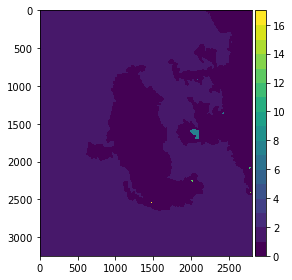

In [477]:
imshow(label_im,cmap=plt.cm.get_cmap('viridis', len(regions)))

In [478]:
import pandas as pd

In [479]:
properties = ['area','convex_area','bbox_area', 'extent',  
              'mean_intensity', 'solidity', 'eccentricity', 
              'orientation']
df = pd.DataFrame(regionprops_table(label_im, array, 
             properties=properties))

In [480]:
df

,area,convex_area,bbox_area,extent,mean_intensity,solidity,eccentricity,orientation
0,6599524,8682672,9107392,0.724634,82.414234,0.760080,0.657015,0.238107
1,66,74,96,0.687500,133.666667,0.891892,0.942624,-0.112992
2,31,36,49,0.632653,148.064516,0.861111,0.799387,-1.097162
3,202,218,253,0.798419,190.009901,0.926606,0.870272,-1.484841
4,8,8,12,0.666667,251.500000,1.000000,0.577350,0.000000
5,375,440,540,0.694444,143.586667,0.852273,0.791391,-0.144815
6,9841,11578,16375,0.600977,95.351692,0.849974,0.812605,0.675620
7,188,193,204,0.921569,245.595745,0.974093,0.752127,-0.067012
8,22,22,30,0.733333,113.090909,1.000000,0.537319,1.570796
9,50,50,56,0.892857,98.540000,1.000000,0.955311,1.551077


In [481]:
max_area = 0
max_area_region_index = 0
for i,v in enumerate(regions):
    if max_area < v.area:
        max_area = v.area
        max_area_region_index = i
    

In [482]:
mask = label_im != max_area_region_index

In [483]:
masked_array = np.ma.masked_array(label_im, mask=mask)
masked_array = np.ma.filled(masked_array, fill_value=1)
masked_array = masked_array.astype(np.uint8)

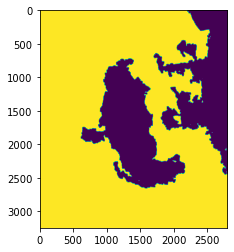

In [484]:
plt.imshow(masked_array)

## write to geotiff

In [485]:
! rm tmp.tif
! rm tmp.geojson

rm: cannot remove 'tmp.tif': No such file or directory
rm: cannot remove 'tmp.geojson': No such file or directory


In [486]:
with rasterio.open(
    'tmp.tif',
    'w',
    driver='GTiff',
    height=masked_array.shape[0],
    width=masked_array.shape[1],
    count=1,
    dtype=masked_array.dtype,
    crs=source.crs,
    transform=source.transform,
) as dst:
    dst.write(masked_array, 1)

In [487]:
! gdal_polygonize.py tmp.tif tmp.geojson

Several drivers matching geojson extension. Using GeoJSON
Creating output tmp.geojson of format GeoJSON.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [507]:
diffs = sorted(glob.glob('data/diff*.tif'))
gdf = gpd.read_file('data/south_cascade_rgi_polygon.geojson')
gdf_new = gpd.read_file('tmp.geojson')
gdf_new = gdf_new[gdf_new.intersects(gdf.geometry[0])]
gdf_new = gdf_new[gdf_new['DN']==0]

'data/diff_dem_ref_1970-09-29.tif'

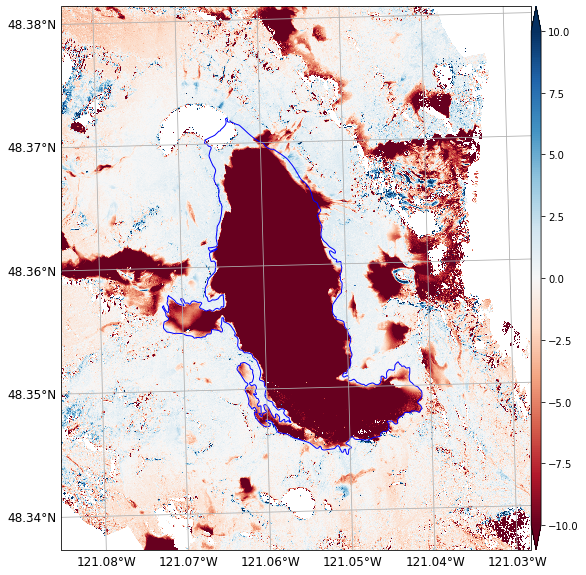

In [509]:
gpoly.plotting.plot_tif(diffs[0], 
                        glacier_outline_gdf=gdf, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
diffs[0]

'data/diff_dem_ref_1970-09-29.tif'

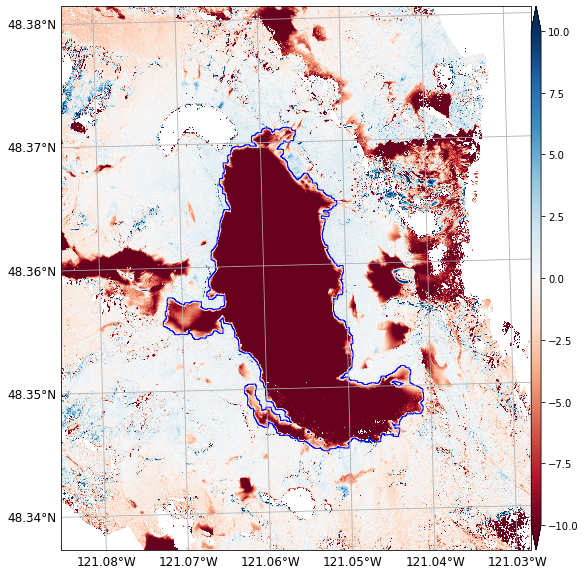

In [510]:
gpoly.plotting.plot_tif(diffs[0], 
                        glacier_outline_gdf=gdf_new, 
                        vmin=-10,vmax=10,
                        cmap='RdBu')
diffs[0]

## Scrap

https://medium.com/swlh/image-processing-with-python-connected-components-and-region-labeling-3eef1864b951

https://towardsdatascience.com/image-processing-blob-detection-204dc6428dd

https://medium.com/swlh/image-processing-with-python-image-segmentation-using-rg-chromaticity-9568c3276db6

In [ ]:
def replace_and_fill_nodata_value(array, nodata_value, fill_value):
    """
    Replace nodata values with fill value in array.
    Parameters
    ----------
    array : numpy.ndarray
    nodata_value : value similar to array.dtype
    fill_value : value similar to array.dtype
    Returns
    -------
    masked_array : numpy.ndarray
    """
    if np.isnan(nodata_value):
        masked_array = np.nan_to_num(array, nan=fill_value)
    else:
        mask = array == nodata_value
        masked_array = np.ma.masked_array(array, mask=mask)
        masked_array = np.ma.filled(masked_array, fill_value=fill_value)

    return masked_array

from skimage.io import imread, imshow

img = imread(diffs[0])

mask = img<0
masked_array = np.ma.masked_array(img, mask=mask)
masked_array = np.ma.filled(masked_array, fill_value=0)

## Derive additional candidate predictors from DEM
https://gdal.org/programs/gdaldem.html

In [ ]:
# %%bash
# cd data/

# fn_list=$(ls dem*.tif)
#
# parallel --progress "gdaldem hillshade {} hs_{.}.tif" ::: $fn_list
# rename 's/hs_dem/hillshade/g' hs_dem*.tif
#
# parallel --progress "gdaldem slope {} sl_{.}.tif" ::: $fn_list
# rename 's/sl_dem/slope/g' sl_dem*.tif
#
# parallel --progress "gdaldem aspect {} asp_{.}.tif" ::: $fn_list
# rename 's/asp_dem/aspect/g' asp_dem*.tif
#
# parallel --progress "gdaldem TRI {} TRI_{.}.tif" ::: $fn_list
# rename 's/TRI_dem/TRI/g' TRI_dem*.tif
#
# parallel --progress "gdaldem roughness {} rn_{.}.tif" ::: $fn_list
# rename 's/rn_dem/roughness/g' rn_dem*.tif

# cd ..

In [ ]:
hillshades = sorted(glob.glob('data/hillshade*.tif'))
TRIs = sorted(glob.glob('data/TRI*.tif'))
slopes = sorted(glob.glob('data/slope*.tif'))
aspects = sorted(glob.glob('data/aspect*.tif'))
roughness = sorted(glob.glob('data/roughness*.tif'))

## Hillshade

In [ ]:
gpoly.plotting.plot_tif(hillshades[0], 
                        glacier_outline_gdf=gdf)

## Slope

In [ ]:
gpoly.plotting.plot_tif(slopes[0], 
                        glacier_outline_gdf=gdf)

## Aspect

In [ ]:
gpoly.plotting.plot_tif(aspects[0], 
                        glacier_outline_gdf=gdf)

## Roughness

In [ ]:
gpoly.plotting.plot_tif(roughness[1], 
                        vmin=0,
                        vmax=100,
                        glacier_outline_gdf=gdf)